In [1]:
using Plots
#using PlotlyJS
using Random, Distributions, StatsBase, LinearAlgebra, DelimitedFiles
Random.seed!()

TaskLocalRNG()

In [8]:
# get observed data and known covariates
io = open("../data/input/X.txt","r")
X = readdlm(io, Float64)
close(io)

io = open("../data/input/Y.txt","r")
Y = readdlm(io, Float64)
close(io)

N = length(X[1,:])
P = length(X[:,1])
K = 4     # I know that the data was generate with K = 4. In principle one should do model selection to discover it

4

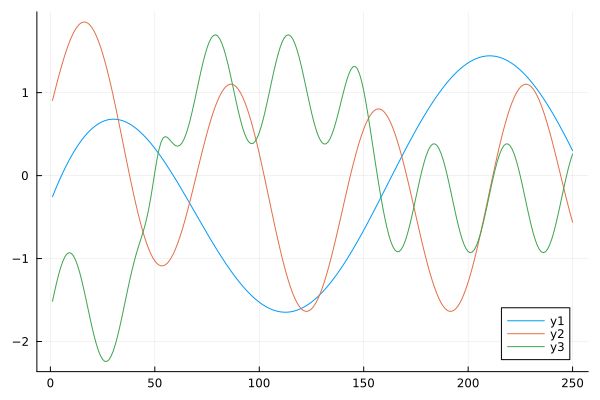

In [6]:
plot(X[1,:])
plot!(X[2,:])
plot!(X[3,:])
#plot!(X[4,:])

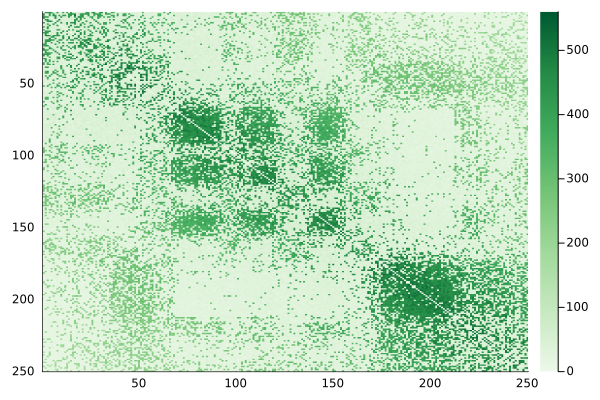

In [7]:
heatmap(Y, yflip=true,c = :Greens_7)

Variational Inference algorithm
=======

In [50]:
# variational parameters for the E-step
ϕ = ones(N,N,K) .* 1/K  # initialized as uniform distributions
λ = randn(N,K)    # mean vectors for the gaussians for every node
ν = [Matrix(1.0I, K, K) for i in 1:N] # covariance matrices for the gaussians. This is a vector of matrices

# parameters to be optimized in the M-step
Σ = Matrix(1.0I, K, K)    # global covariance matrix
σ = rand(Gamma(1,1), K);      # prior covariance on the transformation coefficients Γ
B = rand(Gamma(5,5) ,K,K)
ρ = 0.1

0.1

ELBO
---
We define now a function to compute the approximated ELBO, which we need to monitor in order to asses convergence of the optimization procedure. The explicit expression for it is 
\begin{align}
    \mathcal{L} 
    = & \frac{N}{2} \log |\pmb{\Sigma}^{-1}| - \frac{1}{2}\sum_{i=1}^N [ (\pmb{\lambda}_i - \pmb{\mu}_i)^T \pmb{\Sigma}^{-1} (\pmb{\lambda}_i - \pmb{\mu}_i) + \text{Tr}(\pmb{\Sigma}^{-1} \pmb{\nu}_i) ] + \sum_{i \neq j}^N \sum_{k=1}^K \phi_{ij,k} \lambda_{i,k} \\
    & - (N-1)\sum_{i=1}^N \left( \log \sum_{k'=1}^K \exp (\lambda_{i,k'}) + \frac{1}{2} \text{Tr}\{ ( \text{diag} (\pmb{\theta}(\pmb{\lambda}_i)) - \pmb{\theta}(\pmb{\lambda}_i) \pmb{\theta}(\pmb{\lambda}_i)^T ) \pmb{\nu}_i \} \right) \\
    & + \sum_{i=1}^N \sum_{j=1}^{i-1} \sum_{k,g=1}^K \phi_{ij,k} \phi_{ji,g} \log P (Y_{ij}| B_{k,g}, \rho) + \frac{1}{2} \sum_{i=1}^N \log |\pmb{\nu}_i| -\sum_{i \neq j }^N \sum_{k=1}^K \phi_{ij,k} \log \phi_{ij,k}
\end{align}
